In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import glob 

In [6]:
def plot_regrets(arrs, labels, data, X): 
    """
    in: 
        arrs: list of regrets [n,T] 
        labels: list of str 
    """
    n = len(arrs)
    cmap = plt.cm.get_cmap('jet')
    colors = cmap(np.arange(cmap.N))
    cinv = cmap.N / (1. * n) 
    markers=['.','o','v','^','<','>','1','2','3','4','8','s','p','P','*','h','H','+','x','X','D','d','|','_']

     #arrs[0].shape[-1]
    fig, ax = plt.subplots(figsize=(4, 3), nrows=1, ncols=1)
    # t = np.arange(T)
    # xs = np.arange(T)
    for i, arr, l in zip(range(n), arrs, labels):
        # arr = arr[:,:T] # truncate as different algo can have different iteration length 
        mean = np.mean(arr, axis=0)
        std = np.std(arr, axis=0) / np.sqrt(arr.shape[0])
        ax.plot(X, mean, label=l, marker=markers[i % len(markers)], markevery=10, color=colors[int((i+0.5)*cinv)]) 
        ax.fill_between(X, mean + 1.96*std, mean-1.96*std, alpha=0.1, color=colors[int((i+0.5)*cinv)])

    ax.set_title('{}'.format(data))
    ax.set_xlim([0,X[-1]])
    # ax.set_ylim([-3.2,-1])
    ax.set_xlabel('K') 
    # ax.set_ylabel(r'$\log$' + '(SubOpt)')
    ax.grid('on')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


    return fig 

algo: LinLCB, n: 3
(3, 100)
algo: LinPER, n: 3
(3, 100)
algo: NeuralGreedy, n: 3
(3, 100)
algo: NeuraLCBDiag, n: 3
(3, 100)
algo: NeuralPER, n: 3
(3, 100)


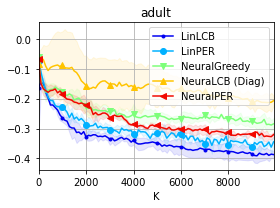

In [7]:
data = 'adult'
func_label = data #r'$r(x,a) = \exp(-10 (x^T \theta_a)^2)$'
result_path = os.path.join('/scratch/tnguy258/neuralofflinerl-2/results/mu_eps=0.5', data)
# algos = ['NeuralUCB', 'NeuralTS', 'NeuralPR', 'NeuralBoot', 'NeuralGreedy', 'NeuralRandVI', 'NeuralRandEx'] 
algos =  [ 'LinLCB', 'LinPER', 'NeuralGreedy','NeuraLCBDiag',  'NeuralPER'] 
algo_labels = ['LinLCB', 'LinPER',  'NeuralGreedy', 'NeuraLCB (Diag)', 'NeuralPER'] 
# algo_labels = algos
# T = 500
arrs = []
upd_times = [] 
act_select_times = []
X = None
for algo in algos: 
    arr = []
    upd_time = [] 
    act_select_time = []
    data_path = os.path.join(result_path, algo) 
    n = len(glob.glob1(data_path,"*.npz"))
 
    # n = 1
    print('algo: {}, n: {}'.format(algo, n))
    for i in range(n): 
        tmp = np.load(os.path.join(result_path, algo, 'trial={}.npz'.format(i)))
        arr.append( np.log(tmp['arr_0'][:,1]) ) 

        if X is None: 
            X = tmp['arr_0'][:,0]
        # Only use the first trial to count elapsed time as running multiple trials does not give a reliable measure of time
        # After running for each algo to get reget, run each algo one more time with trial=0 only to get a measure of time
        # if i == 0: 
        upd_time.append(tmp['arr_1'][:,1])
        act_select_time.append(tmp['arr_2'][:,1]) 
    
    arr = np.array(arr) # (n,T)
    print(arr.shape)
    upd_time = np.array(upd_time) 
    act_select_time = np.array(act_select_time)
    # print(act_select_time.shape)
    arrs.append(arr)
    upd_times.append(upd_time)
    act_select_times.append(act_select_time) # (n_algo, T)
fig = plot_regrets(arrs, algo_labels, func_label, X)

fig.savefig(os.path.join(result_path, '{}_regret.png'.format(data)), bbox_inches='tight', dpi=400)

# act_select_times = np.array(act_select_times)


In [4]:
x = np.array(act_select_times) # (n, trial, t)
print(x.shape)

(5, 3, 100)


(0.0, 9900.0)

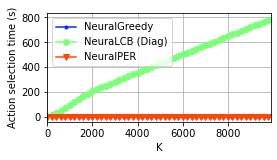

In [5]:
act_select_times = np.array(act_select_times) # (n, trial, t)

mu_time = np.mean(act_select_times, axis=1)
std_time = np.std(act_select_times, axis=1) / np.sqrt(act_select_times.shape[1])


n = 3
cmap = plt.cm.get_cmap('jet')
colors = cmap(np.arange(cmap.N))
cinv = cmap.N / (1. * n) 
markers=['.','o','v','^','<','>','1','2','3','4','8','s','p','P','*','h','H','+','x','X','D','d','|','_']

fig = plt.figure(figsize=(4,2))
for j,i in enumerate([-3,-2,-1]):
    plt.plot(X, mu_time[i], label=algo_labels[i],marker=markers[j % len(markers)], markevery=2, color=colors[int((j+0.5)*cinv)])
    plt.fill_between(X, mu_time[i] + 1.96 * std_time[i], mu_time[i] - 1.96 * std_time[i], color=colors[int((j+0.5)*cinv)], alpha=0.2)

plt.grid('on')
plt.xlabel('K') 
plt.ylabel('Action selection time (s)')

plt.legend(loc='upper left')
plt.xlim([0,X[-1]])
# plt.ylim([-50, mu_time[-3][T] ])
# fig.savefig(os.path.join(result_path, '{}_time.png'.format(data)), bbox_inches='tight', dpi=400)